In [1]:
import nltk
from nltk.corpus import brown
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

import numpy as np
from collections import defaultdict
from tqdm import tqdm

# Download required NLTK data
nltk.download('brown')
nltk.download('universal_tagset')


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\ROG\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\ROG\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [2]:
# Get all sentences from the Brown corpus with universal tagset
tagged_sents = brown.tagged_sents(tagset='universal')

# Count occurrences of each tag
tag_counts = [tag for sent in tagged_sents for _, tag in sent]


In [3]:
set(tag_counts)

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [4]:
# Readme
# HMMTagger class: Implements the core HMM algorithm, including training and the Viterbi algorithm for decoding.
# prepare_data(): Prepares the Brown corpus data.
# evaluate_tagger(): Evaluates the tagger on test data.
# cross_validate(): Performs 5-fold cross-validation.
# main(): Orchestrates the entire process and prints the results.

In [101]:
class HMMTagger:
    def __init__(self):
        self.tag_counts = defaultdict(int)
        self.transition_counts = defaultdict(lambda: defaultdict(int))
        self.emission_counts = defaultdict(lambda: defaultdict(int))
        self.vocab = set()

    def train(self, tagged_sentences):
        for sentence in tagged_sentences:
            prev_tag = '<START>'
            for word, tag in sentence:
                self.tag_counts[tag] += 1
                self.transition_counts[prev_tag][tag] += 1
                self.emission_counts[tag][word] += 1
                self.vocab.add(word)
                prev_tag = tag

        # After training, calculate unknown token emission for each tag
        for tag in self.tag_counts:
            self.emission_counts[tag]['<UNK>'] = 1  # A small probability for unseen words (can be tuned)

    def viterbi(self, sentence):
        V = [{}]
        path = {}
        
        # Initialize base cases (t == 0)
        for tag in self.tag_counts:
            # Use the 'UNKNOWN' token if the word is not in the emission counts
            first_word_emission_prob = self.emission_counts[tag].get(sentence[0], self.emission_counts[tag].get('<UNK>', 0))
            V[0][tag] = self.transition_counts['<START>'].get(tag, 0) * first_word_emission_prob
            path[tag] = [tag]
        
        # Run Viterbi for t > 0
        for t in range(1, len(sentence)):
            V.append({})
            newpath = {}
            for tag in self.tag_counts:
                (prob, state) = max((V[t-1][prev_tag] * 
                                     self.transition_counts[prev_tag].get(tag, 0) * 
                                     self.emission_counts[tag].get(sentence[t], self.emission_counts[tag].get('<UNK>', 0)), prev_tag) 
                                    for prev_tag in self.tag_counts)
                V[t][tag] = prob
                newpath[tag] = path[state] + [tag]
            path = newpath
        
        # Find the highest probability in the final state
        (prob, state) = max((V[len(sentence) - 1][tag], tag) for tag in self.tag_counts)
        return path[state]

    def tag(self, sentence):
        # Replace unknown words with the '<UNK>' token
        processed_sentence = [word if word in self.vocab else '<UNK>' for word in sentence]
        
        # Run Viterbi algorithm on the processed sentence
        return self.viterbi(processed_sentence)


def prepare_data():
    tagged_sents = brown.tagged_sents(tagset='universal')
    print(f"Number of tagged sentences is {len(tagged_sents)}")
    return [([(word.lower(), tag) for word, tag in sent]) for sent in tagged_sents]

def evaluate_tagger(tagger, test_data):
    true_tags = []
    pred_tags = []
    for sentence in test_data:
        words = [word for word, _ in sentence]
        true = [tag for _, tag in sentence]
        # print('words')
        # print(words)
        pred = tagger.tag(words)
        # print('pred')
        # print(pred)
        true_tags.extend(true)
        pred_tags.extend(pred)
    return true_tags, pred_tags

def cross_validate(data, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    all_true_tags = []
    all_pred_tags = []

    progress = 0
    for train_index, test_index in kf.split(data):
        train_data = [data[i] for i in train_index]
        test_data = [data[i] for i in test_index]

        tagger = HMMTagger()
        tagger.train(train_data)

        true_tags, pred_tags = evaluate_tagger(tagger, test_data)
        accuracies.append(accuracy_score(true_tags, pred_tags))
        all_true_tags.extend(true_tags)
        all_pred_tags.extend(pred_tags)

        progress += 1
        print(f"Progress: {progress}")

    return accuracies, all_true_tags, all_pred_tags



# Main code

In [102]:
print("Preparing data")
data = prepare_data()
print("Data prepared")


Preparing data
Number of tagged sentences is 57340
Data prepared


In [114]:
print("Cross-validating")
accuracies, true_tags, pred_tags = cross_validate(data)
print("Cross-validation done")

Cross-validating
Progress: 1
Progress: 2
Progress: 3
Progress: 4
Progress: 5
Cross-validation done


In [ ]:
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")

cm = confusion_matrix(true_tags, pred_tags)
print("Confusion Matrix:")
print(cm)

unique_tags = sorted(set(true_tags))
per_pos_accuracy = {}
for i, tag in enumerate(unique_tags):
    true_pos = cm[i, i]
    total = np.sum(cm[i, :])
    per_pos_accuracy[tag] = true_pos / total

print("\nPer-POS Accuracy:")
for tag, acc in per_pos_accuracy.items():
    print(f"{tag}: {acc:.4f}")


Average Accuracy: 0.7090
Standard Deviation: 0.0059
Confusion Matrix:
[[104836      0      0      0      0      0      0      0      0      0
       0  42729]
 [     0  53049     63   1196      0      0   5013      2      0     11
     599  23788]
 [    13     34 107107    267     69    205    110      0      6    300
     151  36504]
 [     0   2539   2337  37721     32    320   1389      0      0    252
     203  11446]
 [     0      0    133    130  26401    122      5      0      0      0
       0  11360]
 [     0      0    737     12     12 102102     24      0    295      0
       0  33837]
 [     0    407     18     39      1     74 194199      1      3     15
    1268  79533]
 [     0      3      7      0      0      0   2423   8096      0      0
       0   4345]
 [     0      0   1197      2      0   1015     57      0  39005     19
       0   8039]
 [     0    202   9488    565      0      1    376      0     11  13365
      57   5764]
 [     0    204     85     41      0    

In [ ]:
def calculate_metrics(true_tags, pred_tags):
    unique_tags = sorted(set(true_tags))
    
    # Calculate precision, recall, and F1 score for each tag
    precision, recall, f1, _ = precision_recall_fscore_support(true_tags, pred_tags, labels=unique_tags, average=None)
    
    # Calculate macro-averaged F1 score
    macro_f1 = np.mean(f1)
    

    
    return unique_tags, precision, recall, f1, macro_f1

In [ ]:
unique_tags, precision, recall, f1, macro_f1 = calculate_metrics(true_tags, pred_tags)

In [ ]:
f0_5 = []
f2 = []

for i in range(len(unique_tags)):
    f0_5.append(1.25 * precision[i] * recall[i] / (0.25 * precision[i] + recall[i]))
    f2.append(5 * precision[i] * recall[i] / (4 * precision[i] + recall[i]))

f0_5 = np.array(f0_5)
f2 = np.array(f2)

In [111]:
f05_macro = np.mean(f0_5)
f1_macro = np.mean(f1)
f2_macro = np.mean(f2)

print(f05_macro, f1_macro, f2_macro)

0.8098915761445667 0.7241095014123192 0.6578671614309174


In [112]:
p_macro = np.mean(precision)
r_macro = np.mean(recall)

print('p_macro', p_macro)
print('r_macro', r_macro)

p_macro 0.883264433638339
r_macro 0.6897799776106281


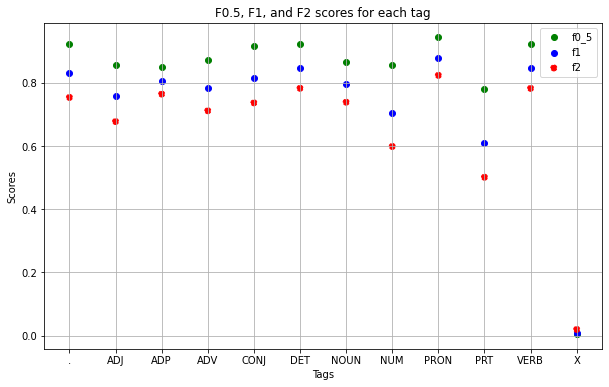

In [107]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.gca().set_facecolor('white')
plt.scatter(unique_tags, f0_5, label='f0_5', color='g')
plt.scatter(unique_tags, f1, label='f1', color='b')
plt.scatter(unique_tags, f2, label='f2', color='r', linestyle='--')
plt.title('F0.5, F1, and F2 scores for each tag')
plt.xlabel('Tags')
plt.ylabel('Scores')
plt.legend()
plt.grid(True)
plt.show()


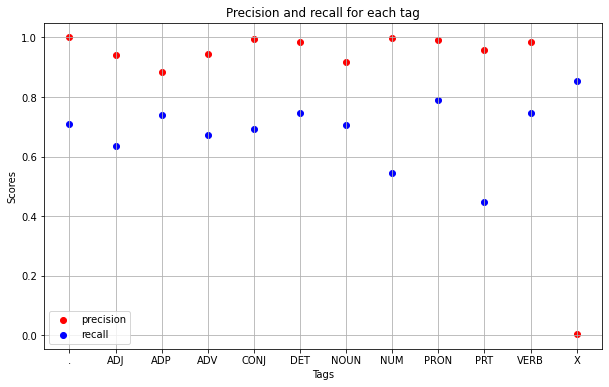

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(unique_tags, precision, label='precision', color='r')
plt.scatter(unique_tags, recall, label='recall', color='b')
plt.title('Precision and recall for each tag')
plt.xlabel('Tags')
plt.ylabel('Scores')
plt.legend()
plt.grid(True)
plt.show()

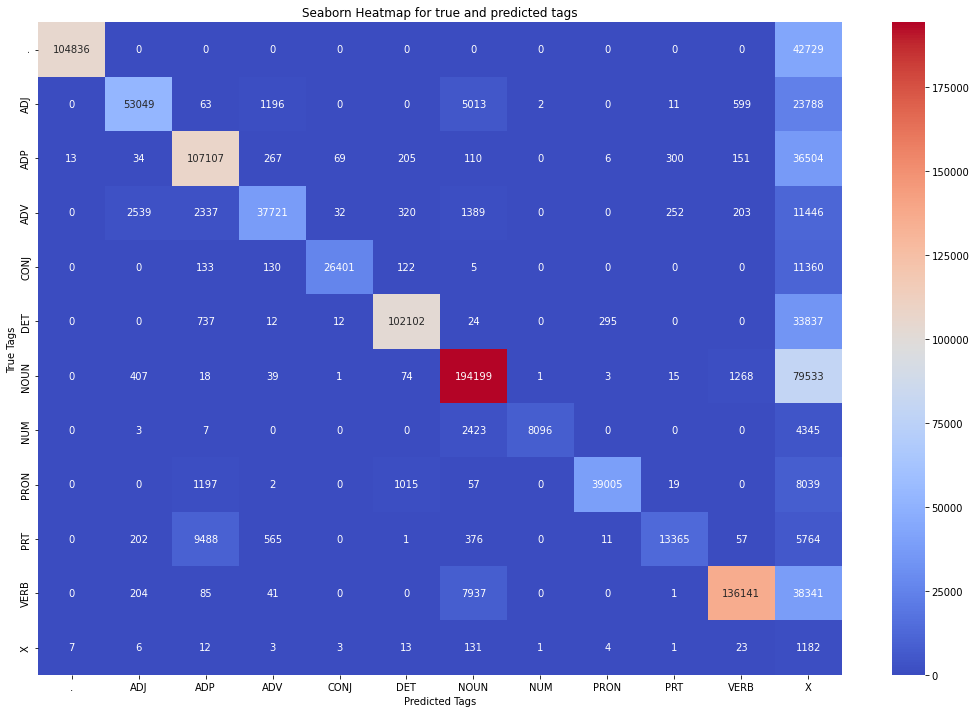

In [ ]:
import seaborn as sns

plt.figure(figsize=(18, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=unique_tags, yticklabels=unique_tags)

plt.title('Seaborn Heatmap for true and predicted tags')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')

plt.xlabel('Predicted Tags')
plt.ylabel('True Tags')

# Display the heatmap
plt.show()

In [17]:
# A lot of nouns are getting predicted as X giving false positives for X (the least frequent tag) [less precision]
#  and false negatives for NOUN (the most frequent tag) [less recall].

In [89]:
tagger = HMMTagger()
tagger.train(data)


In [90]:
# len(tagger.vocab)
tagger.tag_counts
        # self.tag_counts = defaultdict(int)
        # self.transition_counts = defaultdict(lambda: defaultdict(int))
        # self.emission_counts = defaultdict(lambda: defaultdict(int))
        # self.vocab = set()

defaultdict(int,
            {'DET': 137019,
             'NOUN': 275558,
             'ADJ': 83721,
             'VERB': 182750,
             'ADP': 144766,
             '.': 147565,
             'ADV': 56239,
             'CONJ': 38151,
             'PRT': 29829,
             'PRON': 49334,
             'NUM': 14874,
             'X': 1386})

In [91]:
sent = ['the', 'jury', 'said', 'it', 'did', 'find', 'that', 'many', 'of', "georgia's", 'registration', 'and', 'election', 'laws', '``', 'are', 'outmoded', 'or', 'inadequate', 'and', 'often', 'ambiguous', "''", '.']
# sent = [ (word.lower(), '') for word in sent]
tags = tagger.tag(sent)
tags

['DET',
 'NOUN',
 'VERB',
 'PRON',
 'VERB',
 'VERB',
 'ADP',
 'ADJ',
 'ADP',
 'NOUN',
 'NOUN',
 'CONJ',
 'NOUN',
 'NOUN',
 '.',
 'VERB',
 'NOUN',
 'CONJ',
 'ADJ',
 'CONJ',
 'ADV',
 'ADJ',
 '.',
 '.']

In [92]:
kf = KFold(n_splits=2, shuffle=True, random_state=42)
accuracies = []
all_true_tags = []
all_pred_tags = []

progress = 0
for train_index, test_index in kf.split(data):
    train_data = [data[i] for i in train_index]
    test_data = [data[i] for i in test_index]

    tagger.train(data)

    for sentence in test_data:
        words = [word for word, _ in sentence]
        true = [tag for _, tag in sentence]

        words = sent
        print(words)
        print(type(words))

        print(tagger.tag(words))
        break

['the', 'jury', 'said', 'it', 'did', 'find', 'that', 'many', 'of', "georgia's", 'registration', 'and', 'election', 'laws', '``', 'are', 'outmoded', 'or', 'inadequate', 'and', 'often', 'ambiguous', "''", '.']
<class 'list'>
['DET', 'NOUN', 'VERB', 'PRON', 'VERB', 'VERB', 'ADP', 'ADJ', 'ADP', 'NOUN', 'NOUN', 'CONJ', 'NOUN', 'NOUN', '.', 'VERB', 'NOUN', 'CONJ', 'ADJ', 'CONJ', 'ADV', 'ADJ', '.', '.']
['the', 'jury', 'said', 'it', 'did', 'find', 'that', 'many', 'of', "georgia's", 'registration', 'and', 'election', 'laws', '``', 'are', 'outmoded', 'or', 'inadequate', 'and', 'often', 'ambiguous', "''", '.']
<class 'list'>
['DET', 'NOUN', 'VERB', 'PRON', 'VERB', 'VERB', 'ADP', 'ADJ', 'ADP', 'NOUN', 'NOUN', 'CONJ', 'NOUN', 'NOUN', '.', 'VERB', 'ADJ', 'CONJ', 'ADJ', 'CONJ', 'ADV', 'ADJ', '.', '.']


In [93]:
tagger.train(data)

In [100]:
new_sentence = ['the', '', 'said', 'it', 'did', 'find', 'that', 'many', 'of', "georgia's"]
tagger.tag(new_sentence)

['DET', 'NOUN', 'VERB', 'PRON', 'VERB', 'VERB', 'ADP', 'ADJ', 'ADP', 'NOUN']

In [105]:
new_sentence = "The quick brown fox jumps over the lazy dog".split()
print(new_sentence)
print(len(new_sentence))
tagged = tagger.tag(new_sentence)
print(tagged)
print(len(tagged))

['The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']
9
['DET', 'ADJ', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN']
9
